# Dataset Prep File

In [1]:
# LIBRARIES
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from aif360.datasets import GermanDataset # <-- DATASET

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score,r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
# ESTABLISH PARAMETERS
percent_test = 0.33
batch_size = 64
learning_rate = 0.01
epochs = 700

In [3]:
# GET DATA
# - pulling data from the aif360 library
# - using this library does require some setup

label_map = {0.0: 'Good Credit', 1.0: 'Bad Credit'}
protected_attribute_maps = [{1.0: 'Male', 0.0: 'Female'}]

data = GermanDataset(
    protected_attribute_names=['sex'],
    privileged_classes=[['male']],
    metadata={'label_map':label_map,'protected_attribute_maps': protected_attribute_maps})
data.labels = data.labels- 1

protectedCatColumns = ['sex']
protectedColIndex_X=[data.feature_names.index(col) for col in protectedCatColumns]
protectedColIndex_X

X = data.features
y = data.labels.ravel()

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (1000, 58)
Shape of y: (1000,)


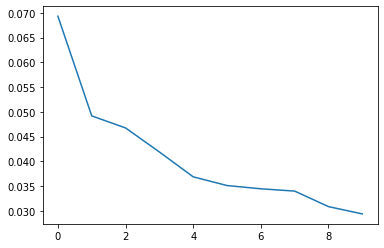

In [4]:
pca = PCA(n_components=10,svd_solver='arpack')
pca.fit(X_scaled)

plt.plot(pca.explained_variance_ratio_)
X_pca = pca.transform(X_scaled)

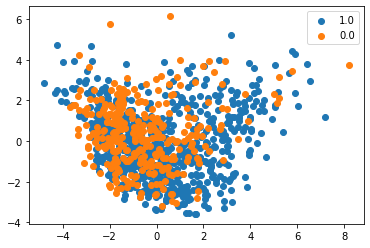

In [5]:
fig, ax = plt.subplots()
scatter_x = X_pca[:,0]
scatter_y = X_pca[:,1]
group = X[:,protectedColIndex_X]
for g in np.flip(np.unique(group)):
    i = np.where(group == g)[0]
    ax.scatter(scatter_x[i], scatter_y[i], label=g)
ax.legend()
plt.show()

In [6]:
np.flip(np.unique(group))

array([1., 0.])

In [7]:
# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y,test_size=percent_test)

print("Train Size: {}".format(X_train.shape[0]))
print("Test Size:  {}".format(X_test.shape[0]))

Train Size: 670
Test Size:  330


## Modeling: Neural Net

In [21]:
class dataset(Dataset):
    
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length

class Net(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()
        # self.fc1 = nn.Linear(input_shape,32)
        # self.fc2 = nn.Linear(32,64)
        # self.fc3 = nn.Linear(64,1)
        # self.predict=nn.Linear(input_shape,1)
        
        self.l1 = nn.Linear(input_shape,32)
        self.l2 = nn.Linear(32,1)
        
    def forward(self,x):
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = torch.sigmoid(self.fc3(x))
        
        # x = torch.sigmoid(self.predict(x))
        
        x = torch.relu(self.l1(x))
        x = torch.sigmoid(self.l2(x))
        return x

In [22]:
# SETUP
trainset = dataset(X_train,y_train)
trainloader = DataLoader(trainset,batch_size=batch_size,shuffle=False)

model = Net(input_shape=X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

epoch 0	loss : 0.6762151718139648	 accuracy : 0.6666666666666666
epoch 50	loss : 0.4739798903465271	 accuracy : 0.7333333333333333
epoch 100	loss : 0.4251139461994171	 accuracy : 0.8
epoch 150	loss : 0.40610578656196594	 accuracy : 0.8333333333333334
epoch 200	loss : 0.3957180976867676	 accuracy : 0.8666666666666667
epoch 250	loss : 0.3882347047328949	 accuracy : 0.8666666666666667
epoch 300	loss : 0.38150784373283386	 accuracy : 0.8333333333333334
epoch 350	loss : 0.3754873275756836	 accuracy : 0.8333333333333334
epoch 400	loss : 0.37030908465385437	 accuracy : 0.8333333333333334
epoch 450	loss : 0.36528271436691284	 accuracy : 0.8333333333333334
epoch 500	loss : 0.3603086769580841	 accuracy : 0.8333333333333334
epoch 550	loss : 0.35478073358535767	 accuracy : 0.8666666666666667
epoch 600	loss : 0.34905898571014404	 accuracy : 0.8666666666666667
epoch 650	loss : 0.34351691603660583	 accuracy : 0.8666666666666667


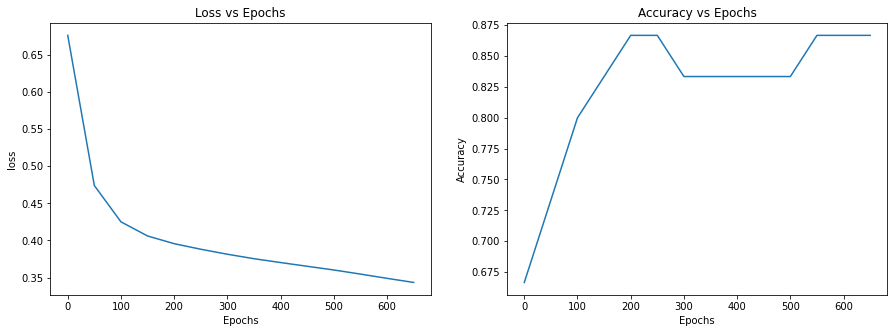

In [23]:
# TRAINING
epoch = []
losses = []
accur = []

for i in range(epochs):
    for j,(x_this,y_this) in enumerate(trainloader):

        #calculate output
        output = model(x_this)

        #calculate loss
        loss = loss_fn(output,y_this.reshape(-1,1))

        #accuracy
        # predicted = model(torch.tensor(x,dtype=torch.float32))
        # print(np.unique(predicted.reshape(-1).detach().numpy().round()))
        # print(np.unique(y))
        # print(np.unique(predicted.reshape(-1).detach().numpy().round() == y))
        # print(str(output[0])+','+str(y_train[0]))
        # print(
        acc = (output.reshape(-1).detach().numpy().round() == y_this.detach().numpy()).mean()
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i%50 == 0:
        epoch.append(i)
        losses.append(loss.item())
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))
        

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epoch,losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(epoch, accur)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [24]:
# GET OVERALL TEST RESULTS
x_tensor = torch.tensor(X_train,dtype=torch.float32)
y_pred = model(x_tensor)
y_train_pred = y_pred.detach().numpy()[:,0]

print('TRAIN Results')
accuracy = accuracy_score(y_train,y_train_pred.round())
r2 = r2_score(y_train,y_train_pred.round())
auc = roc_auc_score(y_train,y_train_pred.round())

print('Accuracy: '+str(accuracy))
print('R2:       '+str(r2))
print('AUC:      '+str(auc))

TRAIN Results
Accuracy: 0.7731343283582089
R2:       -0.08971066598185229
AUC:      0.6850603492552645


In [25]:
x_tensor = torch.tensor(X_test,dtype=torch.float32)
y_pred = model(x_tensor)
y_test_pred = y_pred.detach().numpy()[:,0]


print('TEST Results')
accuracy = accuracy_score(y_test,y_test_pred.round())
r2 = r2_score(y_test,y_test_pred.round())
auc = roc_auc_score(y_test,y_test_pred.round())

print('Accuracy: '+str(accuracy))
print('R2:       '+str(r2))
print('AUC:      '+str(auc))

# pd.crosstab(df_test['y_true'],df_test['y_pred'], rownames=['Actual'], colnames=['Predicted'])

TEST Results
Accuracy: 0.7151515151515152
R2:       -0.33384932920536636
AUC:      0.6313209494324045


In [26]:
# df = pd.DataFrame(X_test, columns=data.feature_names)
df = pd.DataFrame(X_test)
df['y_true'] = y_test
df['y_pred_score'] = y_test_pred
df['y_pred'] = y_test_pred.round()

# show confusion matrix
pd.crosstab(df['y_true'],df['y_pred'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0.0,1.0
Actual,,
0.0,194,34
1.0,60,42
